# 3D Printer DataSet for Mechanical Engineers

Import Data

In [84]:
import statsmodels
import numpy as np
import pandas as pd
import pandashelpers
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.optimize import rosen, differential_evolution
import seaborn as sns
from matplotlib import pyplot as plt

In [79]:
plt.rcParams.update({'font.size': 22})

In [3]:
data = pd.read_csv("data.csv").clean_column_names()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
layer_height          50 non-null float64
wall_thickness        50 non-null int64
infill_density        50 non-null int64
infill_pattern        50 non-null object
nozzle_temperature    50 non-null int64
bed_temperature       50 non-null int64
print_speed           50 non-null int64
material              50 non-null object
fan_speed             50 non-null int64
roughness             50 non-null int64
tension_strength      50 non-null int64
elongation            50 non-null float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [5]:
for column in data.columns:
    print(column)
    print(sorted(data[column].unique()))

layer_height
[0.02, 0.06, 0.1, 0.15, 0.2]
wall_thickness
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
infill_density
[10, 20, 30, 40, 50, 60, 70, 80, 90]
infill_pattern
['grid', 'honeycomb']
nozzle_temperature
[200, 205, 210, 215, 220, 225, 230, 240, 250]
bed_temperature
[60, 65, 70, 75, 80]
print_speed
[40, 60, 120]
material
['abs', 'pla']
fan_speed
[0, 25, 50, 75, 100]
roughness
[21, 24, 25, 30, 32, 40, 55, 60, 68, 74, 75, 88, 92, 118, 120, 121, 126, 128, 138, 144, 145, 154, 163, 168, 172, 176, 180, 192, 200, 212, 220, 225, 244, 265, 276, 278, 289, 298, 312, 321, 326, 357, 360, 368]
tension_strength
[4, 5, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 37]
elongation
[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.7, 2.8, 2.9, 3.1, 3.2, 3.3]


In [6]:
important_features = ['layer_height',
                      'infill_density',
                      'nozzle_temperature',
                      'wall_thickness'
                     ]

In [7]:
y = data[data.columns.intersection(['tension_strength'])]
#x = data[data.columns.difference(['tension_strength','elongation','roughness'])]
x = data[important_features]
x_numeric=x.select_dtypes(include=np.number)
x_nonnumeric=x.select_dtypes(exclude=np.number)
#x = pd.get_dummies(x_nonnumeric).join(x_numeric)

In [8]:
print(x.columns)

Index(['layer_height', 'infill_density', 'nozzle_temperature',
       'wall_thickness'],
      dtype='object')


In [9]:
strength_regressor_rf = RandomForestRegressor()
strength_regressor_rf.fit(x,y.values.reshape(-1))

strength_regressor_linear = LinearRegression()
strength_regressor_linear.fit(x,y.values.reshape(-1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
feature_importance = pd.concat([pd.Series(strength_regressor_rf.feature_importances_,name='importance'),
                                pd.Series(x.columns,name='feature')
                               ],axis=1
                              ).sort_values('importance')

Text(0.5,1,'Tensile Strength')

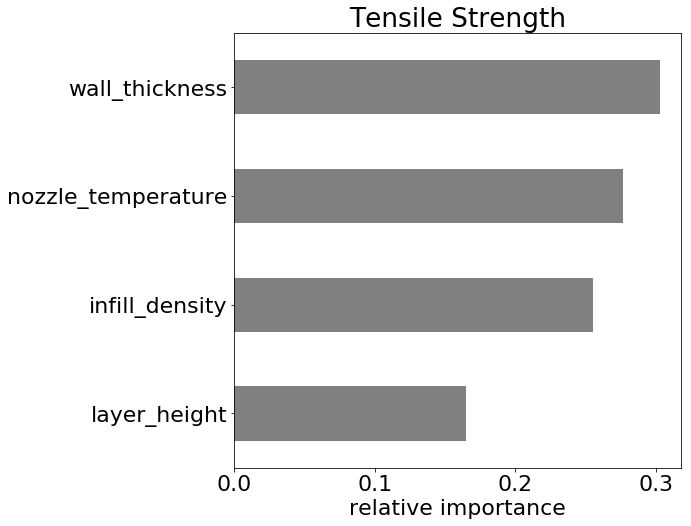

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
feature_importance.plot.barh(x='feature',
                             y='importance',
                             color='grey',
                             legend=False,
                             ax = ax
                             )
ax.set_xlabel('relative importance')
ax.set_ylabel('')
ax.set_title('Tensile Strength')

In [12]:
feature_importance['feature']

0          layer_height
1        infill_density
2    nozzle_temperature
3        wall_thickness
Name: feature, dtype: object

In [13]:
#sns.pairplot(x.join(y))
#sns.heatmap(np.corrcoef(x.join(y)))

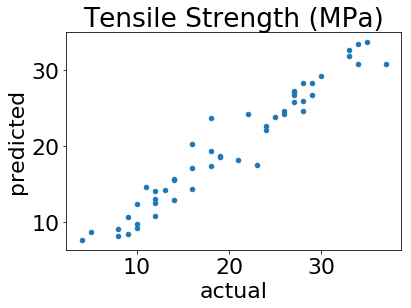

In [14]:
pd.concat([pd.Series(strength_regressor_rf.predict(x),name='predicted'),
           pd.Series(y.values.reshape(-1),name='actual')
          ],axis=1
         ).plot.scatter(x='actual',y='predicted',title='Tensile Strength (MPa)')
  

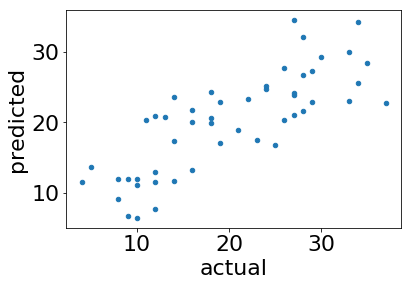

In [15]:
pd.concat([pd.Series(strength_regressor_linear.predict(x),name='predicted'),
           pd.Series(y.values.reshape(-1),name='actual')
          ],axis=1
         ).plot.scatter(x='actual',y='predicted')

In [16]:
metadata = pd.read_csv('metadata.csv')

In [17]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Columns: 145 entries, Unnamed: 0 to z_offset 
dtypes: float64(19), int64(102), object(24)
memory usage: 870.1+ KB


In [18]:
metadata.columns

Index(['Unnamed: 0', '--fill-angle', '--fill-density', '--fill-pattern',
       '--infill-every-layers', '--layer-height', '--perimeters',
       '--solid-infill-speed', '--solid-layers', '--temperature',
       ...
       'top_solid_infill_speed ', 'top_solid_layers ', 'travel_speed ',
       'use_firmware_retraction ', 'use_relative_e_distances ',
       'use_volumetric_e ', 'vibration_limit ', 'wipe ',
       'xy_size_compensation ', 'z_offset '],
      dtype='object', length=145)

In [22]:
strenth_controllable_parameters = ['--layer-height', # layer_height
                                   '--fill-density', # infill_density
                                   '--temperature', # nozzle_temperature
                                   '--solid-layers' # wall_thickness
                                  ]



In [23]:
newx = metadata[strenth_controllable_parameters]
newx.columns

Index(['--layer-height', '--fill-density', '--temperature', '--solid-layers'], dtype='object')

In [24]:
#sns.pairplot(newx)

In [25]:
tensile = strength_regressor_rf.predict(newx)
tensile_series = pd.Series(tensile,name='tensile_strength_predicted')

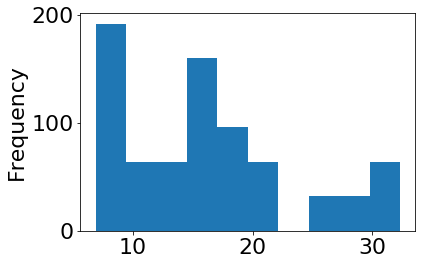

In [26]:
tensile_series.plot.hist()

In [27]:
metadata_enriched = metadata.join(tensile_series)

In [28]:
filament = metadata['filament used '].str.strip(' ')\
                                    .str.split(' ',expand=True)\
                                    .rename(columns={0:'filament_used_mm',
                                                     1:'filament_used_cm3'
                                                    }
                                           )


In [29]:
metadata_enriched['filament_used_mm'] = filament['filament_used_mm']\
.str.replace('mm','')\
.apply(float)

metadata_enriched['filament_used_cm3'] = filament['filament_used_cm3']\
.str.strip('()')\
.str.replace('cm3','')                                                             .apply(float)

In [30]:
metadata_enriched['infill extrusion width (mm)'] = metadata['infill extrusion width '].str.replace('mm','').apply(float)

/home/thom/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(97.2697,0.5,'tensile strength (MPa)')

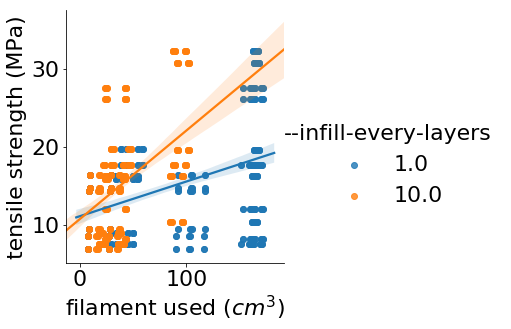

In [48]:
fg = sns.lmplot(x='filament_used_cm3',
                y='tensile_strength_predicted',
                hue='--infill-every-layers',
                #col='--fill-density',
                #row='--layer-height',
                data=metadata_enriched           
          )
fg.axes[0,0].set_xlabel('filament used ($cm^3$)')
fg.axes[0,0].set_ylabel('tensile strength (MPa)')

In [32]:
filament_controllable_parameters = ['--infill-every-layers',
                                    '--fill-density',
                                    '--layer-height',                                    
                                   ]

In [33]:
#metadata[]
y = metadata_enriched[metadata_enriched.columns.intersection(['filament_used_cm3'])]
"""
x = metadata_enriched[metadata_enriched.columns.difference(['filament_used_cm3',
                                                            'filament used ',
                                                            'filament_used_mm',
                                                            'Unnamed: 0',
                                                            'fill_density ',
                                                            'infill_every_layers ',
                                                            'output_filename_format ',
                                                            'fill_pattern ',
                                                            'layer_height ',
                                                            'perimeters ',                                                            
                                                           ])]
x_numeric = x.select_dtypes(include=np.number)
x_non_numeric = x.select_dtypes(exclude=np.number)
x = pd.get_dummies(x_non_numeric).join(x_numeric)
x = x.loc[:,x.var()!=0].dropna(1)
"""
x = metadata_enriched[filament_controllable_parameters]

In [34]:
x.columns

Index(['--infill-every-layers', '--fill-density', '--layer-height'], dtype='object')

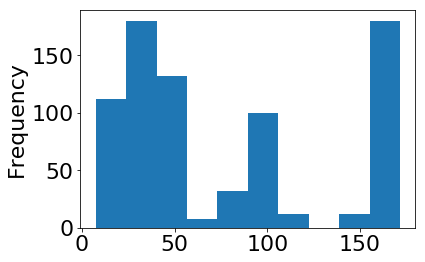

In [36]:
y.plot.hist(legend=False)

In [37]:
filament_regressor_rf = RandomForestRegressor()
filament_regressor_linear = LinearRegression()

In [38]:
filament_regressor_rf.fit(x,y.values.reshape(-1))
#filament_regressor_linear.fit(x_numeric.dropna(1),y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
feature_importance = pd.concat([pd.Series(filament_regressor_rf.feature_importances_,name='importance'),
                                pd.Series(x.columns,name='feature')
                               ],axis=1
                              ).sort_values('importance')

In [40]:
feature_importance.dropna()

,importance,feature
2,0.083673,--layer-height
0,0.450079,--infill-every-layers
1,0.466247,--fill-density


Text(0.5,1,'Filament Usage')

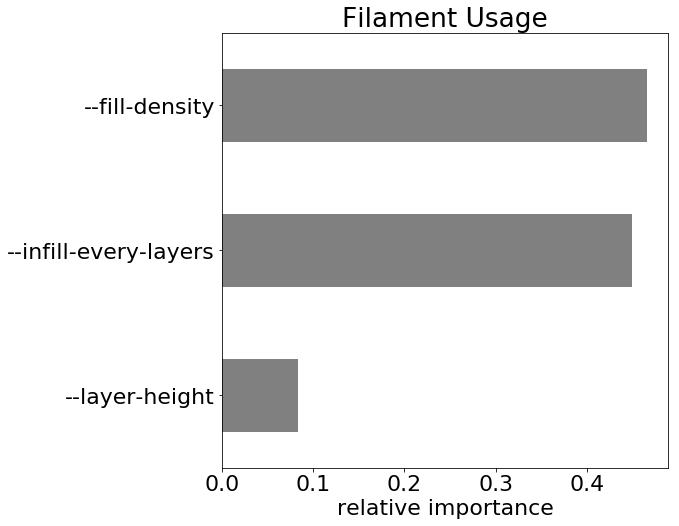

In [41]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))

feature_importance.dropna()[-10:].plot.barh(x='feature',
                                            y='importance',
                                            color='grey',
                                            legend=False,
                                            ax=ax
                                           )


ax.set_xlabel('relative importance')
ax.set_ylabel('')
ax.set_title('Filament Usage')

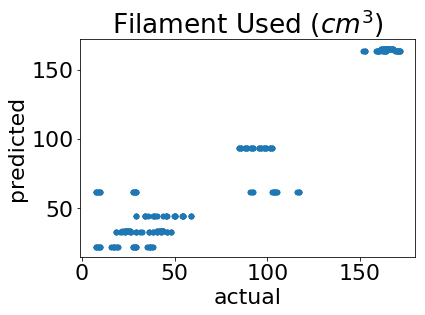

In [49]:
pd.concat([pd.Series(filament_regressor_rf.predict(x),name='predicted'),
           pd.Series(y.values.reshape(-1),name='actual')
          ],axis=1
         ).plot.scatter(x='actual',y='predicted',title='Filament Used ($cm^3$)')


In [89]:
average_filament = metadata_enriched['filament_used_cm3'].mean()
average_strength = metadata_enriched['tensile_strength_predicted'].mean()

15.920833333333334

In [90]:
def cost_function(input_array):
    """
    layer_height,
    fill_densiy,
    infill_every_layers,
    wall_thickness,
    nozzle_temperature
    """
    (layer_height,
     fill_densiy,
     infill_every_layers,
     wall_thickness,
     nozzle_temperature) = input_array
    
    x_strength = pd.Series({'layer_height':layer_height,
                            'fill_densiy':fill_densiy,
                            'wall_thickness':wall_thickness,
                            'nozzle_temperature':nozzle_temperature}
                          )
    
    x_filament = pd.Series({'layer_height':layer_height,
                            'fill_densiy':fill_densiy,
                            'infill_every_layers':infill_every_layers,                  
                           })
    
    
    strength = strength_regressor_rf.predict(x_strength.values.reshape(1, -1))
    filament = filament_regressor_rf.predict(x_filament.values.reshape(1, -1))
    cost = 0.5*filament/average_filament - 0.5*strength/average_strength

    global iteration
    global evolution_df
    
    row = pd.Series(np.append(input_array,(iteration,cost)),index=('layer_height',
                                                                   'fill_density',
                                                                   'infill_every_layers',
                                                                   'wall_thickness',
                                                                   'nozzle_temperature',
                                                                   'iteration',
                                                                   'cost'
                                                                  ))
    evolution_df = evolution_df.append(row, ignore_index=True)
    iteration += 1
    
    return cost
    

In [91]:
strength_controllable_parameters = ['--layer-height',
                                    '--fill-density',
                                    '--temperature',
                                    '--solid-layers'
                                   ]

In [92]:
x.loc[0,filament_controllable_parameters]
#x.loc[0,strength_controllable_parameters]

--infill-every-layers     1.00
--fill-density           10.00
--layer-height            0.02
Name: 0, dtype: float64

In [93]:
cost_function(np.array([0.02,10.00,1,1,200]))

array([-0.22511945])

In [122]:
iteration = 1
evolution_df = pd.DataFrame(columns=['layer_height',
                                     'fill_density',
                                     'infill_every_layers',
                                     'wall_thickness',
                                     'nozzle_temperature',
                                     'iteration',
                                     'cost'
                                    ])
bounds = [(0.02, 0.8), #layer_height
          (10.0, 90.0), #fill_density
          (1.0, 10.0), #infill_every_layers
          (1.0, 10.0), #wall_thickness
          (200, 300)  #nozzle_temperature
         ]
result = differential_evolution(cost_function,
                                bounds,                                
                                #strategy='rand2exp',
                                #maxiter=1000,
                                #popsize=25,
                                #tol=0.001,
                                #mutation=(0.5, 1),
                                #recombination=0.7,
                                #seed=None,                                
                                #disp=False,
                                #polish=True,
                                #init='latinhypercube',
                                #atol=0
                               )
print(result.x, result.fun)

[  0.57153236  46.12917446   4.29097592   4.92265957 276.59808607] -0.5642976767257258


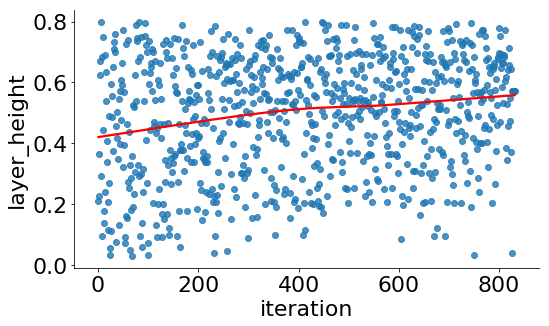

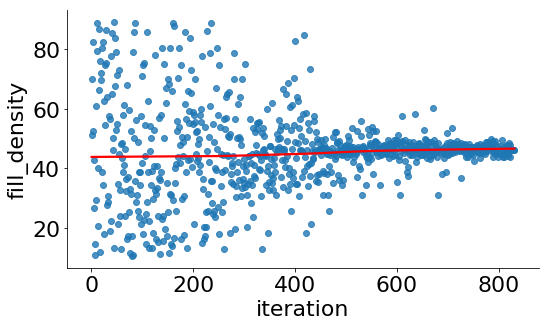

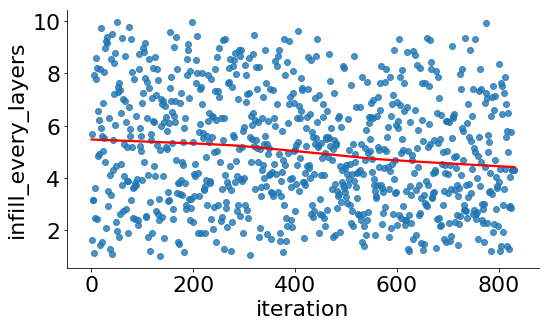

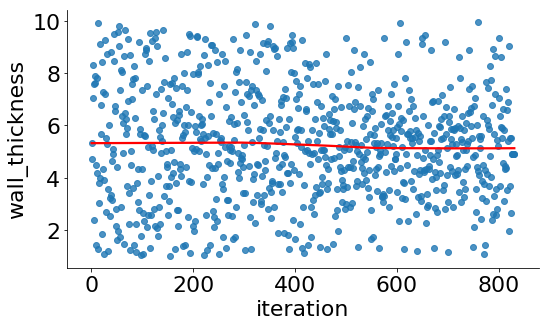

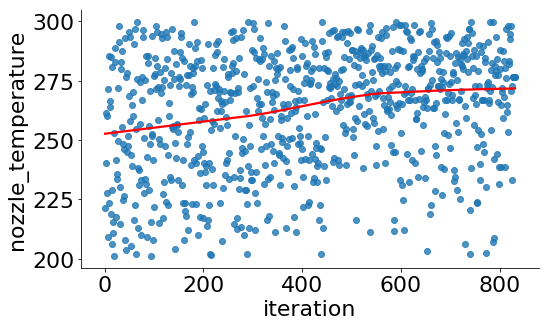

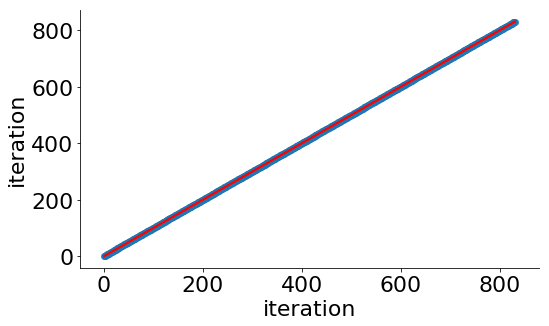

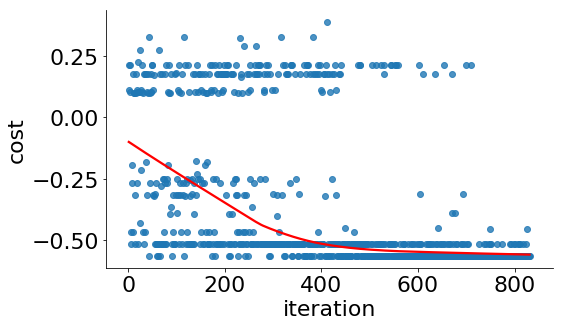

In [132]:

for column in evolution_df.columns:
  sns.lmplot(y=column,
             x='iteration',
             data=evolution_df,
             lowess=True,
             #scatter_kws={'color':'greys'},
             line_kws={'color':'r'},
             aspect=1.618
            )  

In [126]:
#sns.pairplot(evolution_df)
'--layer-height', # layer_height
'--fill-density', # infill_density
'--temperature', # nozzle_temperature
'--solid-layers' # wall_thickness

(0.02, 0.8), #layer_height
(10.0, 90.0), #fill_density
(1.0, 10.0), #infill_every_layers
(1.0, 10.0), #wall_thickness
(200, 300)  #nozzle_temperature

0.57153236
46.12917446
4.29097592
4.92265957
276.59808607

In [7]:
%%sh
slic3r --layer-height 0.57153236 --fill-density 46.12917446 --infill-every-layers 4 --solid-layers 5 --temperature 277 --nozzle-diameter 0.6 '/home/thom/School/2019 S04 Spring/optimization_of_3d_printable_objects/stl_files/largecube.stl'

=> Processing triangulated mesh
=> Generating perimeters
=> Preparing infill
=> Infilling layers
=> Generating skirt
=> Exporting G-code to /home/thom/School/2019 S04 Spring/optimization_of_3d_printable_objects/stl_files/largecube.gcode
Done. Process took 0 minutes and 1.664 seconds
Filament required: 15777.7mm (111.5cm3)
